# Ноутбук с разведочным анализом данных и обработкой пропущнных значений по квартирам, сдающимся в аренду

### Установим и импортируем необходимые библиотеки

In [ ]:
!pip install numpy matplotlib seaborn -q

In [128]:
!pip install geopy -q

In [456]:
!pip install requests -q

In [637]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from geopy.geocoders import Nominatim, Yandex
import re
import warnings
warnings.filterwarnings('ignore')

In [638]:
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 30)

#### Загрузим данные и посмотрим на них

In [639]:
data = pd.read_csv('/home/seppoku/ds_bootcamp/real_estate_rent/data/raw/_data.csv')
data.head()

,Unnamed: 0,ID объявления,Количество комнат,Тип,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление
0,0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157
1,1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126
2,2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086
3,3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456
4,4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615


#### Удалим столбец 'Unnamed: 0'

In [640]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

#### Возьмем колонки до столбца 'ремонт' (так поделились) и назовем колонки по английски

In [641]:
df = data[['ID  объявления', 'Количество комнат', 'Тип', 'Метро', 'Адрес', 'Площадь, м2', 'Дом', 'Парковка', 'Цена', 'Телефоны', 'Описание']]

In [642]:
df.columns = ['announcement_id', 'rooms', 'type', 'subway', 'adress', 'square', 'building', 'parking', 'price', 'contact_phone', 'description']

In [643]:
def is_moscow(text):
    return text.split(',')[0] == 'Москва'

df = df[df['adress'].apply(is_moscow)]
df.reset_index(drop=True)

,announcement_id,rooms,type,subway,adress,square,building,parking,price,contact_phone,description
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов..."
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...
...,...,...,...,...,...,...,...,...,...,...,...
19732,215565511,NaN,Квартира,м. Говорово (8 мин пешком),"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",35.0/16.4/8.0,10/14,NaN,"42000.0 руб./ За месяц, Залог - 42000 руб., Ко...",+79154383401,Сдаётся светлая теплая квартира (студия) с бал...
19733,274654844,1,Квартира,м. Солнцево (7 мин пешком),"Москва, Производственная улица, 8к1, ш. Боровс...",38.7/16.5/11.0,"5/18, Монолитный",NaN,"45000.0 руб./ За месяц, Залог - 45000 руб., Ко...",+79151173402,Сдам однокомнатную квартиру на длительный срок...
19734,268679909,"2, Оба варианта",Квартира,м. Солнцево (6 мин пешком),"Москва, Боровский проезд, 11",43.1,"5/5, Кирпичный",NaN,"50000.0 руб./ За месяц, Залог - 50000 руб., Ко...",+79653825192,Рассматриваются квартиранты только славяне и т...
19735,274807525,2,Квартира,м. Солнцево (11 мин пешком),"Москва, улица Богданова, 6к1, ш. Боровское (3 ...",52.5/10.0,"8/23, Монолитный",наземная,"55000.0 руб./ За месяц, Залог - 50000 руб., Ко...",+79660611965,Двухкомнатная уютная квартира с видом во внутр...


### Посмотрим признак rooms

In [644]:

# оставим только количество комнат, если там пропуск, заменим на 0
df['rooms'] = [int(i.split(', ')[0]) if isinstance(i, str) else 0 for i in df['rooms']] 

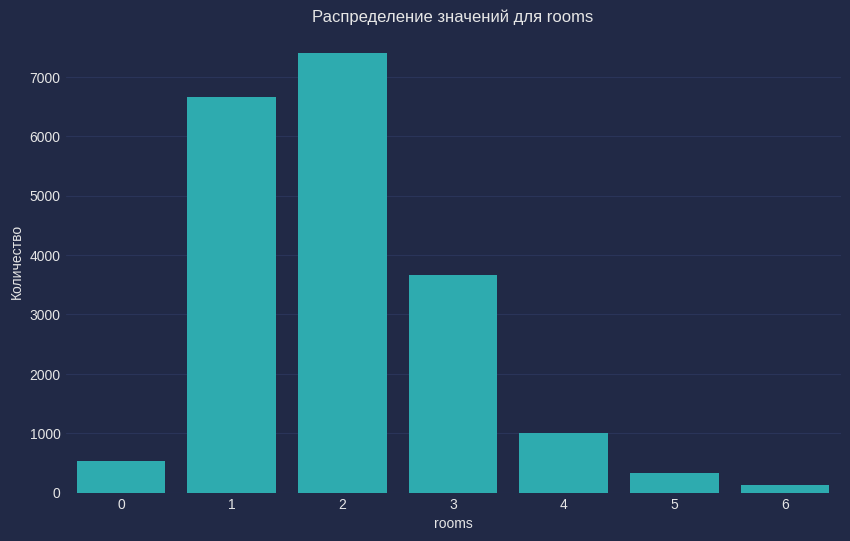

In [645]:
def plot_bar_chart(df, column_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.countplot(data=df, x=column_name, ax=ax)

    ax.set_ylabel('Количество')
    ax.set_title(f'Распределение значений для {column_name}')


plot_bar_chart(df, 'rooms')

##### Видим, что чаще всего сдаются в аренду два пласта - **однушка** и **двушка**

### Посмотрим признак 'parking'

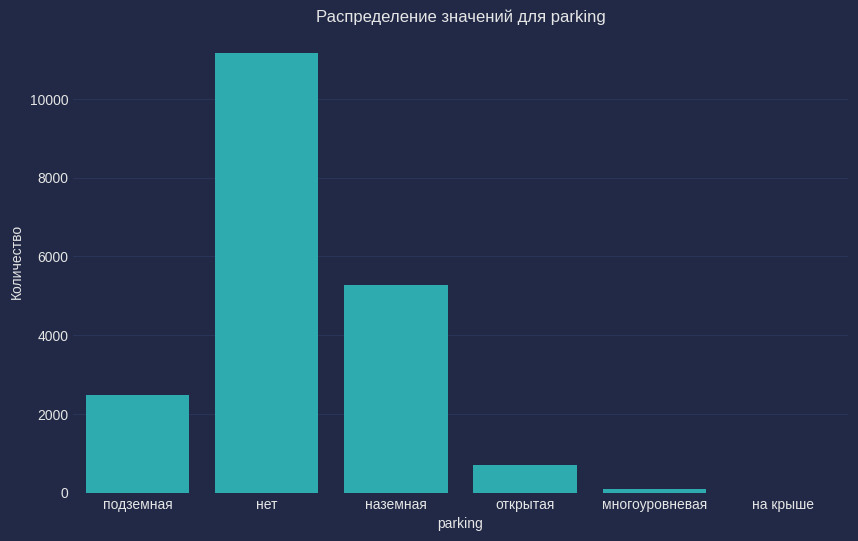

In [646]:
# заменим пропуски на 'во дворе'
df['parking'] = df['parking'].fillna('нет')
plot_bar_chart(df, 'parking')

##### Тут видим, что дома обычно не имеют отдельно построенных парковок, они в основном назменые - либо для **жильцов** либо для **всех кто захочет**

### Рассмотрим признак square

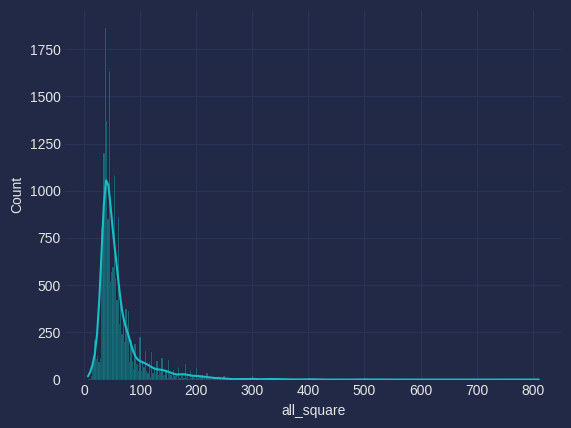

In [647]:
#сделаем новый столбец all_square, который будет в себя включать общую площадь квартиры
df['all_square'] = [i.split('/')[0] for i in df['square']]
df['all_square'] = df['all_square'].astype(float)
sns.histplot(df['all_square'], kde=True);

##### Мы можем видеть, что большинство квартир находятся в диапазоне от 40 до 70 метров квадратных


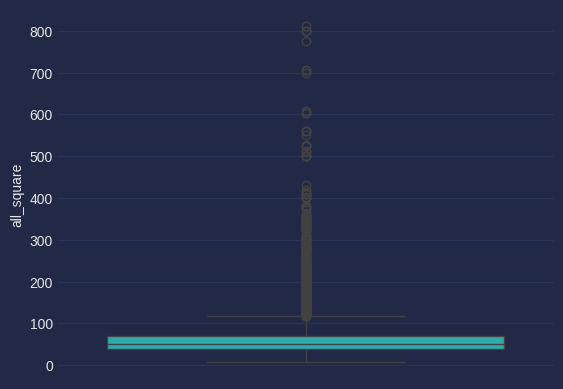

In [648]:
sns.boxplot(df['all_square']);

##### Медианное значение общей площади находится в районе 50, так же есть много квартир 150+ метров, это либо для тусовок посуточно, либо для аренды залов на мероприятия(конференции, свадьбы и тд) надо разбираться

### Посмотрим признак 'type'

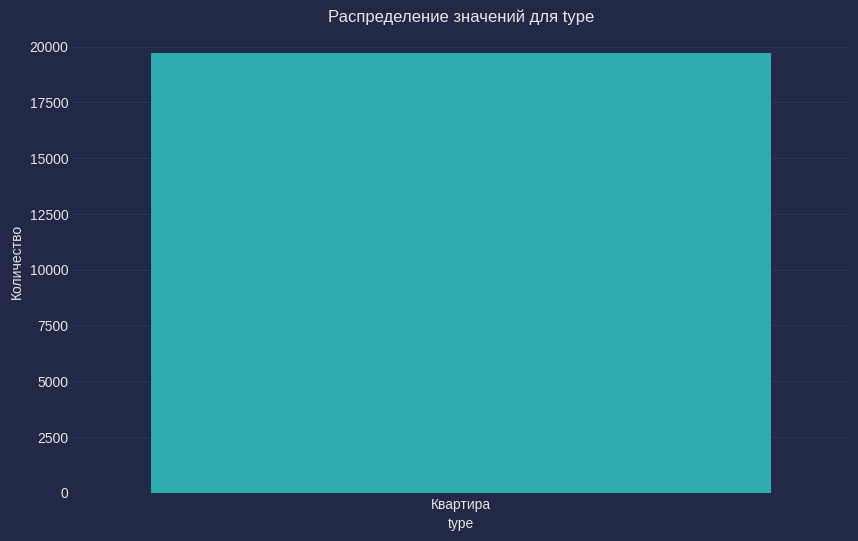

In [649]:
plot_bar_chart(df, 'type')

##### Здесь всего одно значение - **квартира**

### Посмотрим признак 'building'

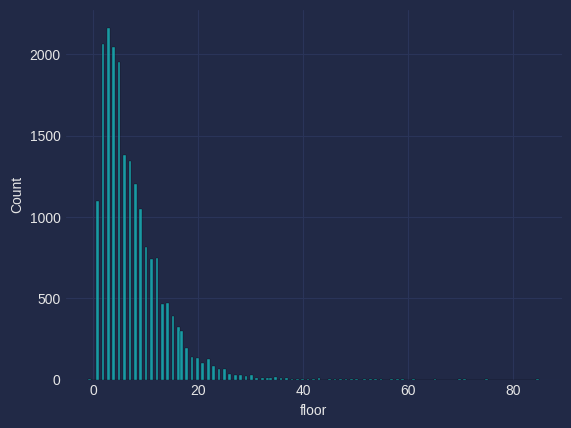

In [650]:
# Создадим столбец 'floor', где будет этаж
df['floor'] = [int(i.split('/')[0]) for i in df['building']]
sns.histplot(df['floor']);

##### Большинство квартир находится на высоте от 1 до 15 этажа

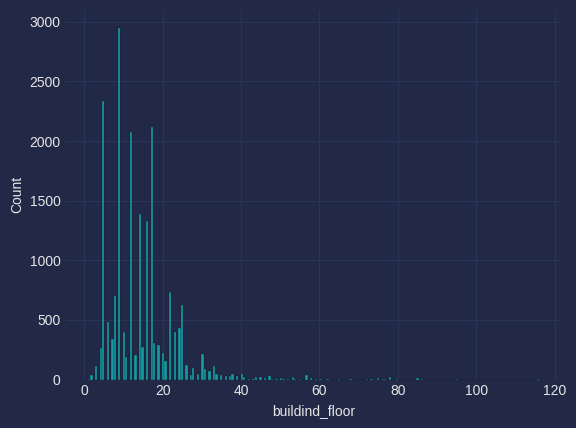

In [651]:
# Создадим столбец 'building_floor', где будет этажность самого здания
df['buildind_floor'] = [int(i.split('/')[1].split(',')[0]) for i in df['building']]
sns.histplot(df['buildind_floor']);

##### Большинство домов высотой - 9, 5, 12, 17, 16 скорее всего это так называемые **панельки** и **сталинки**

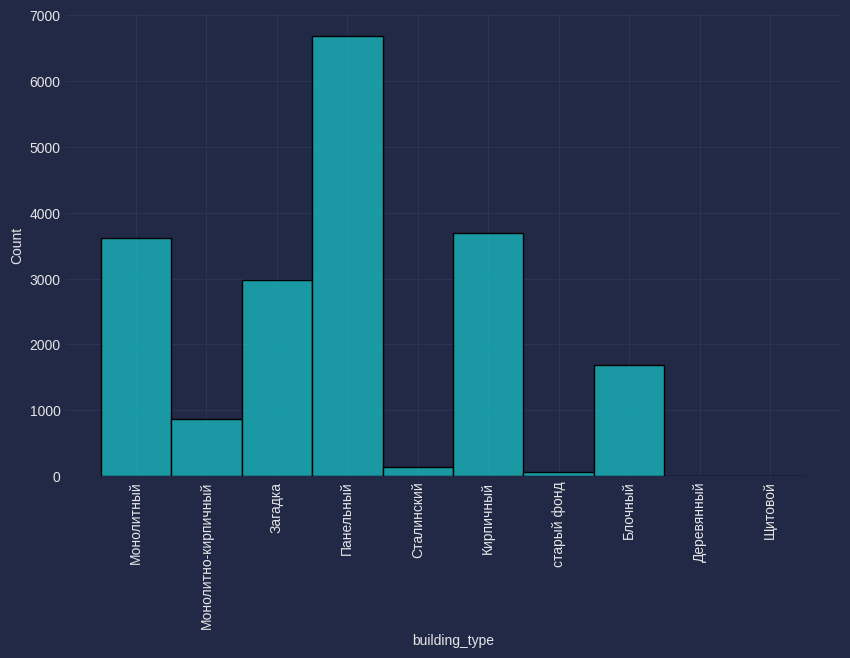

In [652]:
# Создадим столбец 'building_type', где будет тип постройки, если там пропуск - пусть там будет "Загадка"
df['building_type'] = [i.split(', ')[-1] if len(i.split(', ')[-1]) > 6 else 'Загадка' for i in df['building']]


fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['building_type'], ax=ax);
ax.set_xticklabels(df['building_type'].unique(), rotation=90);



##### Больше всего **панелек**, **монолитных** и **кирпичных строений**

## Посмотрим признак цена

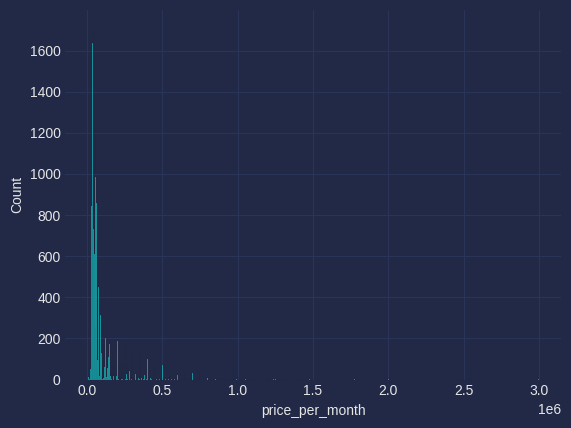

In [653]:
# создадим колонку 'price_per_month' в которой будет отображена стоимость месячной аренды
df['price_per_month'] = [int(i.split('.')[0]) for i in df['price']]
sns.histplot(df['price_per_month']);

In [654]:
df.describe()

,announcement_id,rooms,all_square,floor,buildind_floor,price_per_month
count,1.973700e+04,19737.000000,19737.000000,19737.000000,19737.000000,1.973700e+04
mean,2.671149e+08,1.973451,63.564848,7.520748,14.494097,8.656385e+04
std,1.980106e+07,1.044658,47.944055,5.995302,9.063673,1.281483e+05
min,1.072986e+08,0.000000,7.000000,-1.000000,1.000000,5.000000e+03
25%,2.712212e+08,1.000000,38.900000,3.000000,9.000000,3.999000e+04
50%,2.739284e+08,2.000000,49.800000,6.000000,12.000000,5.000000e+04
75%,2.746973e+08,3.000000,70.000000,10.000000,17.000000,7.500000e+04
max,2.750064e+08,6.000000,811.000000,85.000000,116.000000,3.000000e+06


#### Видим, что минимальная цена аренды 5000 - это либо комната, либо цена в валюте, надо разбираться

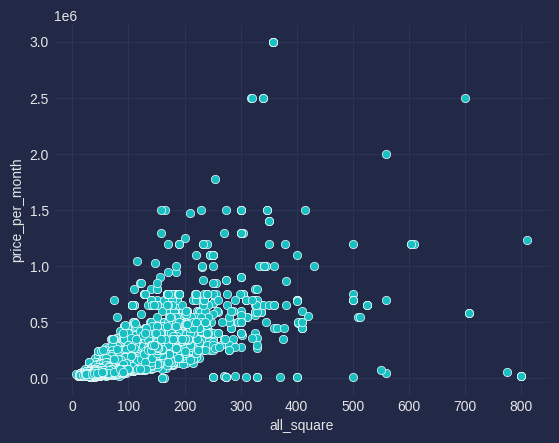

In [655]:
sns.scatterplot(x = df['all_square'], y=df['price_per_month']);


##### Есть выбросы, квартиры с огромной площадью сдаются за очень низкую цену(скорее всего - валюта)

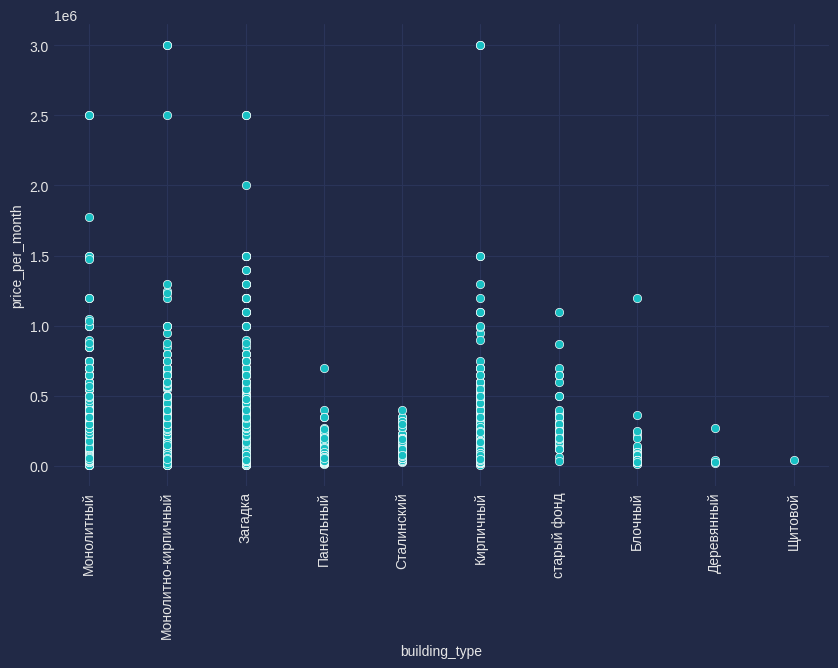

In [656]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x = df['building_type'], y=df['price_per_month'], ax=ax);
ax.set_xticklabels(df['building_type'].unique(), rotation=90);

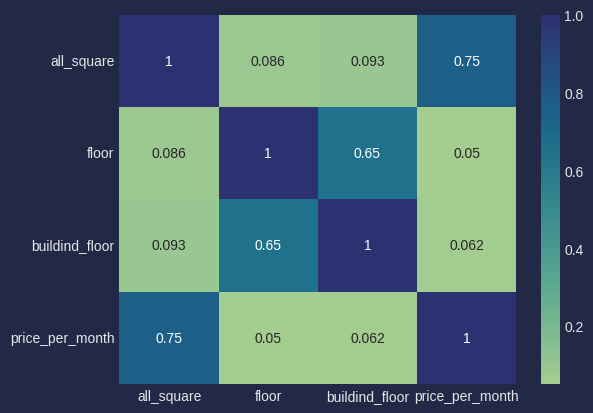

In [657]:
df_corr = df[['all_square', 'floor', 'buildind_floor', 'price_per_month']].corr()

sns.heatmap(df_corr, cmap="crest", annot=True);

##### Видим достаточно сильную корреляцию между ценой и общей площадью

# Небольшой общий вывод:  На первый взгляд данные распределены более менее экспоненциально, с левыми пиками. Выбросы есть, с ними надо будет работать

### Начнем работать с выбросами

In [658]:
# Сделаем признак 'metro', который будет содержать станцию метро
df['metro'] = [i.split(' (')[0].split('. ')[1] if isinstance(i, str) else 'нет' for i in df['subway']]

In [450]:
# регулярка времени до метро \((\w+)\ (\w+)\ (\w+)\)          скок мин, мин\часы, как
# регулярка для станции метро \w\.\ (\w+)\ 

'м. Новаторская (11 мин пешком)'

In [659]:
# Сделаем колонку 'street' которая будет содержать название улицы
df['street'] = [i.split(', ')[1] for i in df['adress']]

In [660]:
df['times'] = [re.findall(r'\((\w+)\ (\w+)\ (\w+)\)', i) if isinstance(i, str) else [(0,0,0)] for i in df['subway']]


# Сделаем колонку 'time' в которой будет время до метро
df['time'] = [re.findall(r'\((\w+)', i)[0] if isinstance(i ,str) else 0 for i in df['subway']]

# Сделаем колонку 'time_type', в которой будет тип времени (минуты/часы)
df['time_type'] = [i[0][1]  if len(i) >= 1 else np.nan for i in df['times']]


#Сделаем колонку 'type_of_movement', в которой будет тип передвежения до метро
df['type_of_movement'] = [i[0][2]  if len(i) >= 1 else np.nan for i in df['times']]

In [661]:
# заменим пропуски в 'time_type' на мин и в 'type_of_movement' на машина
df['time_type'].fillna('мин', inplace=True)
df['type_of_movement'].fillna('машина', inplace=True)


##### Во всех этих колонках у нас остались значения с нулями, ровно там же, где и пропуски в 'subway', если честно, хочется их дропнуть на...)))

In [662]:
# С метро поступим так - где пропуски заполним нет, а время до метро заменим на медианное значение
df['subway'].fillna('нет', inplace=True)
df['time'].replace('None', 0, inplace=True)
df['time'] = df['time'].astype(int)
df['time'].replace(0, df['time'].median(), inplace=True)

In [ ]:
# удалим лишние столбцы 

#df.drop(['subway', 'type', 'square', 'building' и тд])

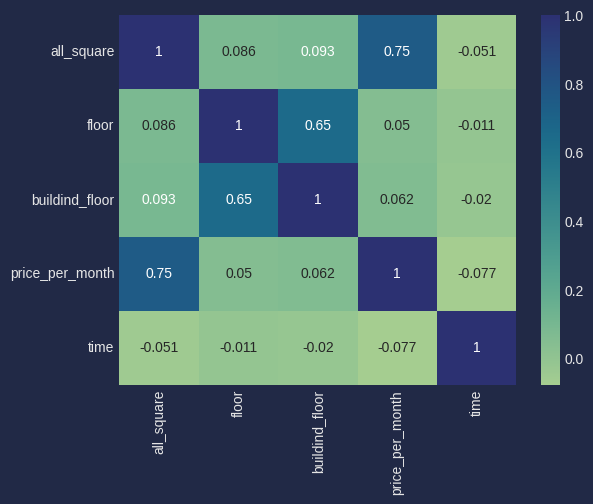

In [663]:
# Посмотрим заново на корреляционную матрицу

df_corr = df[['all_square', 'floor', 'buildind_floor', 'price_per_month', 'time']].corr()

sns.heatmap(df_corr, cmap="crest", annot=True);

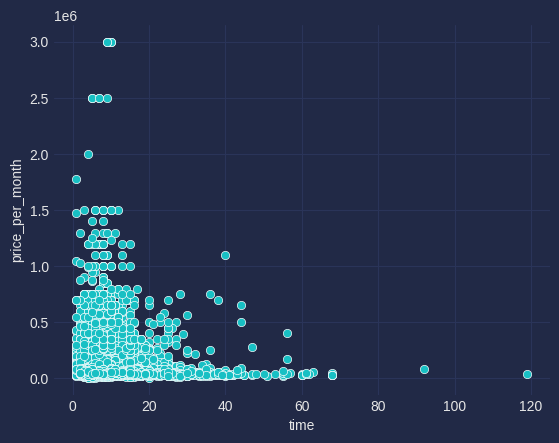

In [664]:
sns.scatterplot(x = df['time'], y = df['price_per_month']);

In [665]:
df.head()

,announcement_id,rooms,type,subway,adress,square,building,parking,price,contact_phone,description,all_square,floor,buildind_floor,building_type,price_per_month,metro,street,times,time,time_type,type_of_movement
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,200.0,5,16,Монолитный,500000,Смоленская,улица Новый Арбат,"[(9, мин, пешком)]",9,мин,пешком
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,198.0,5,16,Монолитно-кирпичный,500000,Смоленская,улица Новый Арбат,"[(8, мин, пешком)]",8,мин,пешком
2,271173086,4,Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",200.0,5,16,Загадка,500000,Смоленская,улица Новый Арбат,"[(7, мин, пешком)]",7,мин,пешком
3,272197456,4,Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,170.0,5,6,Загадка,400000,Смоленская,переулок Плотников,"[(3, мин, пешком)]",3,мин,пешком
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",нет,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,58.0,12,26,Панельный,225000,Арбатская,улица Новый Арбат,"[(7, мин, пешком)]",7,мин,пешком


## Все пропуски были обработаны, так же была сделана выборка только по Москве